In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json

import sys
sys.path.append("../")
from ritini.data_generation.toy_data import create_temporal_graph_data
from ritini.models.gat import TemporalGAT
from ritini.data.temporal_graph import TemporalGraphDataset
from ritini.train import train_epoch

In [2]:
# Data parameters
n_timepoints = 20
n_trajectories = 2
n_genes = 10
batch_size = 1
time_window = 2  # Length of time_window, set to None to use all timepoints
n_change = 5

# Training parameters
n_epochs = 1000
learning_rate = 0.001
n_heads = 1
dropout = 0.1

#Scheduler configs
lr_factor = 0.5
lr_patience = 10

# Create temporal graph data with slow edge changes
all_node_features, all_graphs = create_temporal_graph_data(
    n_timepoints=n_timepoints,
    n_trajectories=n_trajectories,
    n_genes=n_genes,
    edge_density=0.3,
    temporal_noise=0.1,
    n_change=n_change,
    save= True,
)

# Select a single trajectory type for training
trajectory_idx = 0
train_node_features = all_node_features[trajectory_idx]  # Shape: (n_timepoints, n_genes)
train_graphs = all_graphs[trajectory_idx]  # List of n_timepoints graphs

# Extract prior graph (initial graph at t=0)
prior_graph = train_graphs[0]

# Convert prior graph to adjacency matrix
prior_adjacency = torch.zeros(n_genes, n_genes)
for edge in prior_graph.edges():
    prior_adjacency[edge[0], edge[1]] = 1
    prior_adjacency[edge[1], edge[0]] = 1  # Symmetric

print(f"\nPrior graph (t=0): {len(prior_graph.nodes())} nodes, {len(prior_graph.edges())} edges")
print(f"Prior adjacency shape: {prior_adjacency.shape}\n")


Prior graph (t=0): 10 nodes, 25 edges
Prior adjacency shape: torch.Size([10, 10])



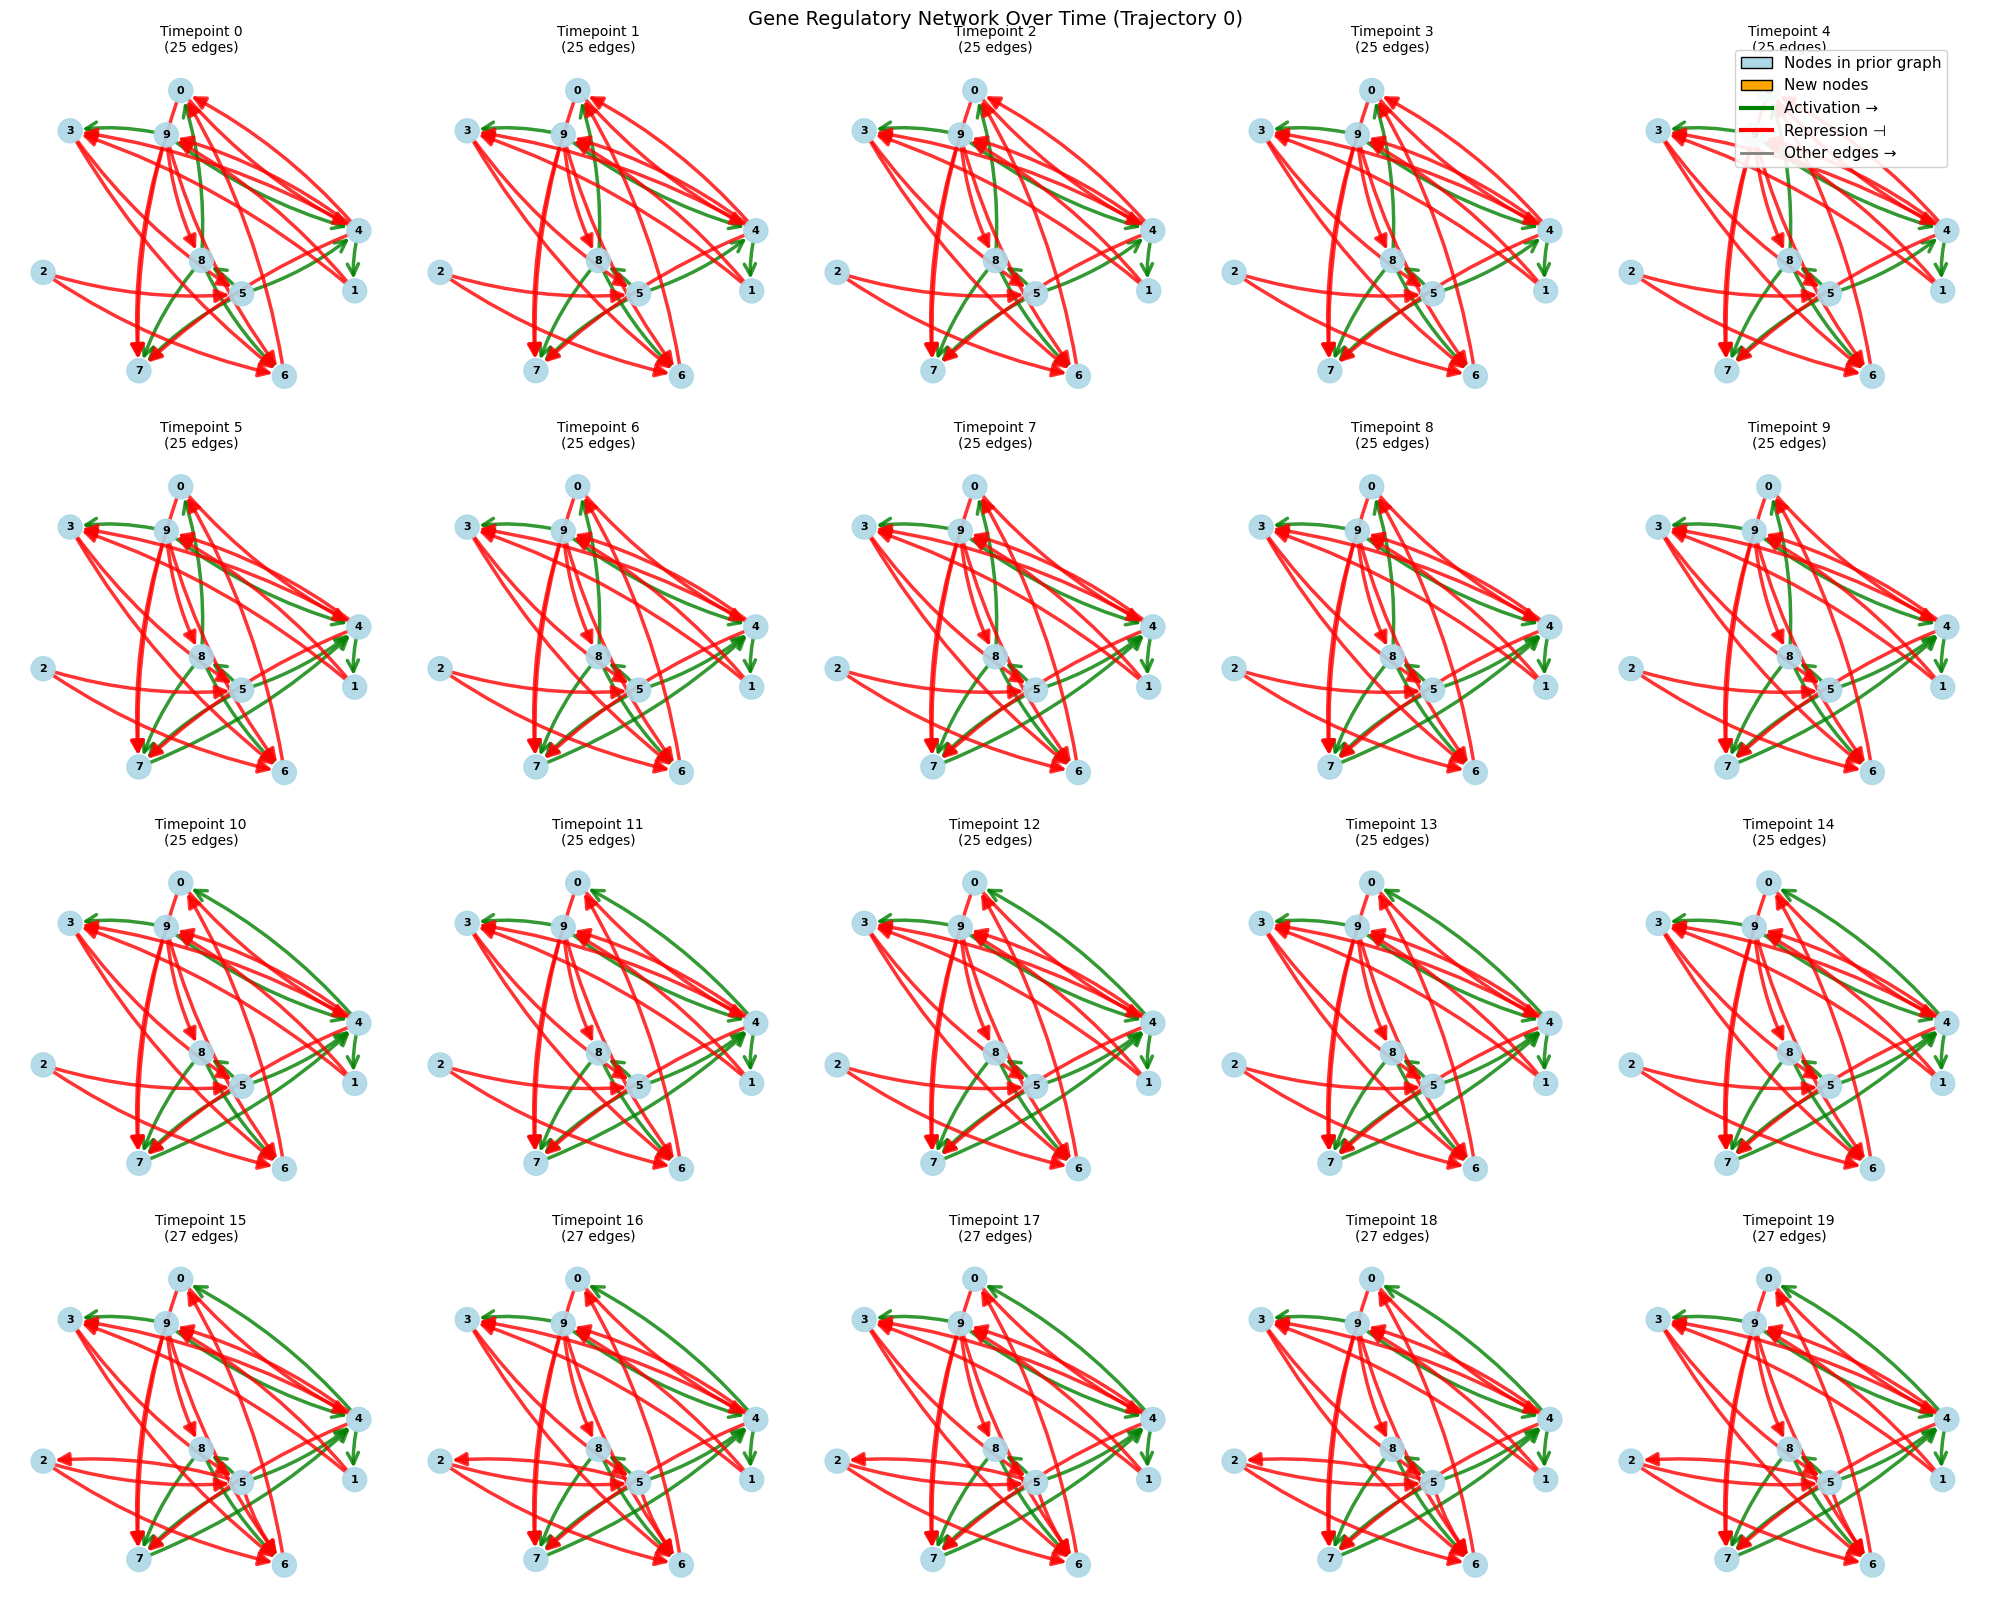

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Get prior graph nodes for reference
prior_nodes = set(prior_graph.nodes())

# Calculate grid dimensions for subplots
n_cols = 5  # Number of columns in the plot grid
n_rows = (n_timepoints + n_cols - 1) // n_cols  # Calculate rows needed

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_timepoints > 1 else [axes]

# Use fixed layout based on first graph for easier comparison
pos = nx.spring_layout(train_graphs[0], seed=42)

# Plot each timepoint
for t in range(n_timepoints):
    G = train_graphs[t]
    ax = axes[t]
    
    # Determine node colors based on whether they're in prior_graph
    node_colors = []
    for node in G.nodes():
        node_colors.append('lightblue')  # Nodes in prior_graph
    
    # Separate edges by regulation type if available
    activation_edges = []
    repression_edges = []
    other_edges = []
    
    for u, v, data in G.edges(data=True):
        if 'regulation' in data:
            if data['regulation'] == 'activation':
                activation_edges.append((u, v))
            elif data['regulation'] == 'repression':
                repression_edges.append((u, v))
            else:
                other_edges.append((u, v))
        else:
            other_edges.append((u, v))
    
    # Draw activation edges first (green arrows)
    if activation_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=activation_edges,
            edge_color='green',
            arrows=True,
            arrowsize=20,
            arrowstyle='->',
            width=2.5,
            alpha=0.8,
            connectionstyle='arc3,rad=0.1',
            ax=ax,
            node_size=300
        )
    
    # Draw repression edges (red arrows with blunt end)
    if repression_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=repression_edges,
            edge_color='red',
            arrows=True,
            arrowsize=20,
            arrowstyle='-|>',
            width=2.5,
            alpha=0.8,
            connectionstyle='arc3,rad=0.1',
            ax=ax,
            node_size=300
        )
    
    # Draw other edges (gray arrows)
    if other_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=other_edges,
            edge_color='gray',
            arrows=True,
            arrowsize=20,
            arrowstyle='->',
            width=2,
            alpha=0.6,
            connectionstyle='arc3,rad=0.1',
            ax=ax,
            node_size=300
        )
    
    # Draw nodes on top of edges
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_colors,
        node_size=300,
        alpha=0.9,
        ax=ax
    )
    
    # Draw node labels
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=8,
        font_weight='bold',
        ax=ax
    )
    
    ax.set_title(f'Timepoint {t}\n({len(G.edges())} edges)', fontsize=10)
    ax.axis('off')

# Hide unused subplots
for t in range(n_timepoints, len(axes)):
    axes[t].axis('off')

# Add legend with improved visibility
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Nodes in prior graph'),
    Patch(facecolor='orange', edgecolor='black', label='New nodes'),
    Line2D([0], [0], color='green', linewidth=3, label='Activation →'),
    Line2D([0], [0], color='red', linewidth=3, label='Repression ⊣'),
    Line2D([0], [0], color='gray', linewidth=2, label='Other edges →')
]
fig.legend(handles=legend_elements, loc='upper right', 
           bbox_to_anchor=(0.98, 0.98), fontsize=11, framealpha=0.9)

plt.tight_layout()
plt.suptitle(f'Gene Regulatory Network Over Time (Trajectory {trajectory_idx})', 
             fontsize=14, y=1.00)
plt.show()